## Community Detection

In [2]:
import community  # python-louvain
import networkx as nx

# Load your saved graph object
G = nx.read_graphml("nz_legislation_network.graphml") 

# Run Louvain algorithm
partition = community.best_partition(G)

# Add community ID as a node attribute
nx.set_node_attributes(G, partition, "community")

In [3]:
#Get the number of communities
num_communities = len(set(partition.values()))
print("Number of communities:", num_communities)

Number of communities: 30


In [5]:
# Calculate modularity
modularity_score = community.modularity(partition, G)
print(f"Modularity score: {modularity_score:.4f}")

Modularity score: 0.3953


Extract Dataframe for Topic Modelling

    Creates a DataFrame of all Acts and their assigned community

In [6]:
import pandas as pd

# Create act-level DataFrame
data = [{"name": G.nodes[node].get("name", node), "community": partition[node]} for node in G.nodes()]
df = pd.DataFrame(data)

In [7]:
df.head()

,name,community
0,Domestic Violence Act 1995,0
1,Arms Act 1983,1
2,Crimes Act 1961,0
3,Family Violence Act 2018,0
4,Family Proceedings Act 1980,13


In [8]:
# Count how many acts are in each community
community_counts = df["community"].value_counts().reset_index()
community_counts.columns = ["community", "act_count"]
print(community_counts)

    community  act_count
0           9        291
1           1        275
2          11        269
3          13        167
4          23        157
5           0        151
6          12        138
7          25         91
8          16         90
9          14         86
10         15         62
11          4         56
12          7         55
13         19         41
14          3          4
15         27          3
16         26          3
17         10          3
18          5          3
19          8          2
20         21          2
21         17          2
22         22          2
23          6          2
24          2          2
25         24          2
26         29          2
27         18          1
28         20          1
29         28          1


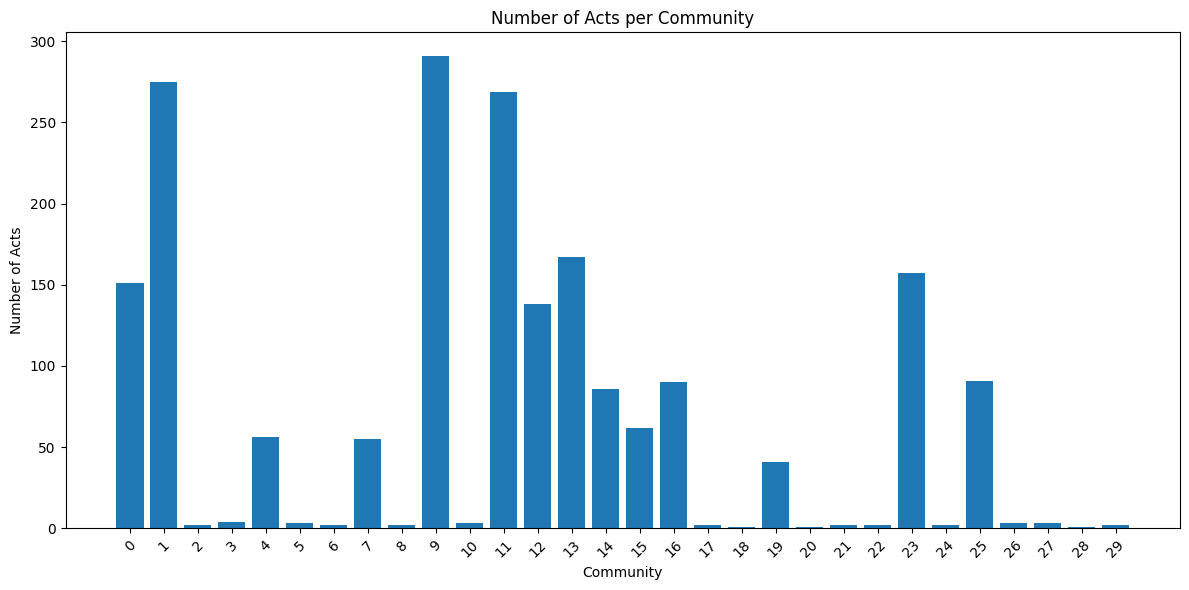

In [9]:
import matplotlib.pyplot as plt

# Sort by community number (optional, for better visualization)
community_counts = community_counts.sort_values("community")

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(community_counts["community"].astype(str), community_counts["act_count"])
plt.xlabel("Community")
plt.ylabel("Number of Acts")
plt.title("Number of Acts per Community")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/9y/3rlj5x9s12b4rh6g81wmnvfc0000gp/T/ipykernel_1593/1766164484.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="community", y="act_count", data=community_counts, palette="viridis")


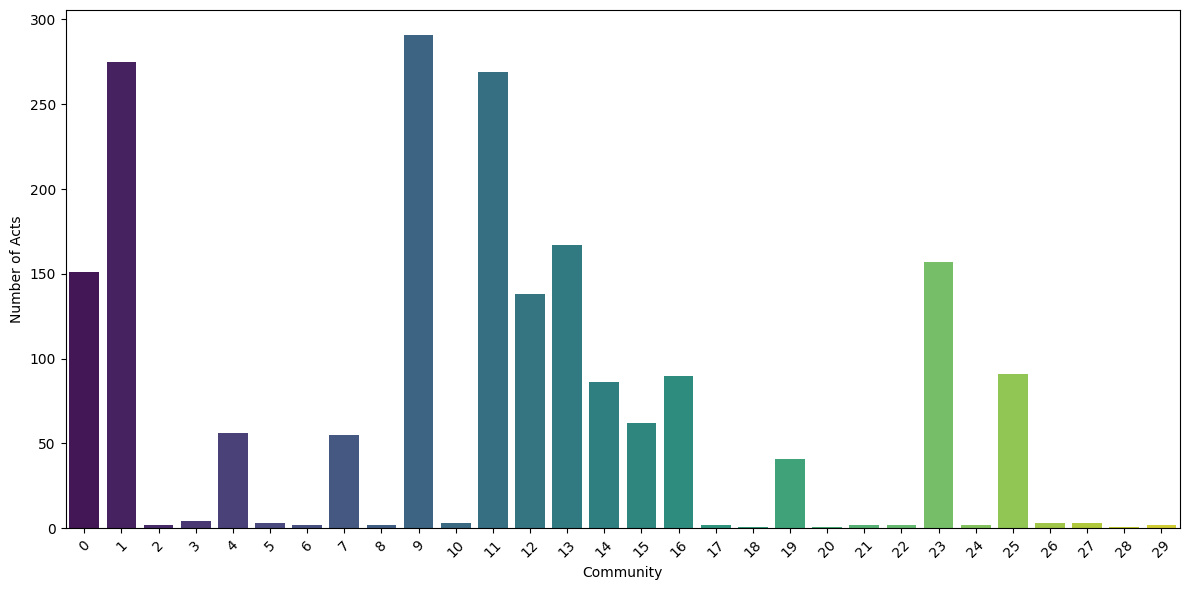

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by act count (optional)
community_counts = community_counts.sort_values("act_count", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="community", y="act_count", data=community_counts, palette="viridis")
plt.xlabel("Community")
plt.ylabel("Number of Acts")
# plt.title("Number of Acts per Community")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Find the communities with less than 5 acts and reassign them

In [37]:
# # Filter sparse ones
# sparse_communities = community_counts[community_counts["act_count"] < 5]

# # Print act names in those communities
# for comm in sparse_communities["community"]:
#     print(f"\n--- Community {comm} ---")
#     print(df[df["community"] == comm]["name"].tolist())

In [38]:
# STEP 2: Count acts per community
community_counts = df["community"].value_counts()
sparse_comms = community_counts[community_counts < 5].index.tolist()
large_comms = community_counts[community_counts >= 5].index.tolist()

# STEP 3: Create combined act titles per community
community_docs = df.groupby("community")["name"].apply(lambda x: " ".join(x)).to_dict()

In [39]:
# Prepare document list for TF-IDF comparison
doc_keys = sparse_comms + large_comms
documents = [community_docs[c] for c in doc_keys]

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# STEP 4: TF-IDF + Cosine similarity
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)
similarities = cosine_similarity(tfidf_matrix[:len(sparse_comms)], tfidf_matrix[len(sparse_comms):])

# STEP 5: Reassign sparse communities to best match
reassign_map = {}
for i, sparse_id in enumerate(sparse_comms):
    best_match_idx = similarities[i].argmax()
    best_match_comm = large_comms[best_match_idx]
    reassign_map[sparse_id] = best_match_comm
    print(f"Community {sparse_id} → reassigned to Community {best_match_comm}")

# STEP 6: Apply reassignment
df["adjusted_community"] = df["community"].replace(reassign_map)

# STEP 7: Save updated data
df.to_csv("acts_with_adjusted_communities.csv", index=False)
print("✅ Saved updated file: acts_with_adjusted_communities.csv")

Community 26 → reassigned to Community 20
Community 4 → reassigned to Community 9
Community 12 → reassigned to Community 18
Community 8 → reassigned to Community 0
Community 11 → reassigned to Community 9
Community 24 → reassigned to Community 18
Community 14 → reassigned to Community 13
Community 25 → reassigned to Community 0
Community 10 → reassigned to Community 17
Community 5 → reassigned to Community 9
Community 2 → reassigned to Community 9
Community 1 → reassigned to Community 7
Community 21 → reassigned to Community 13
Community 23 → reassigned to Community 13
Community 27 → reassigned to Community 22
✅ Saved updated file: acts_with_adjusted_communities.csv


In [41]:
# Count acts per adjusted community
act_counts = df["adjusted_community"].value_counts().sort_index()
print(act_counts)

adjusted_community
0     202
3      57
6      52
7     119
9      63
13    176
15    123
16    174
17     75
18    359
19    194
20    253
22    117
Name: count, dtype: int64


/var/folders/9y/3rlj5x9s12b4rh6g81wmnvfc0000gp/T/ipykernel_12104/1889627742.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=adjusted_counts_df, x="adjusted_community", y="act_count", palette="crest")


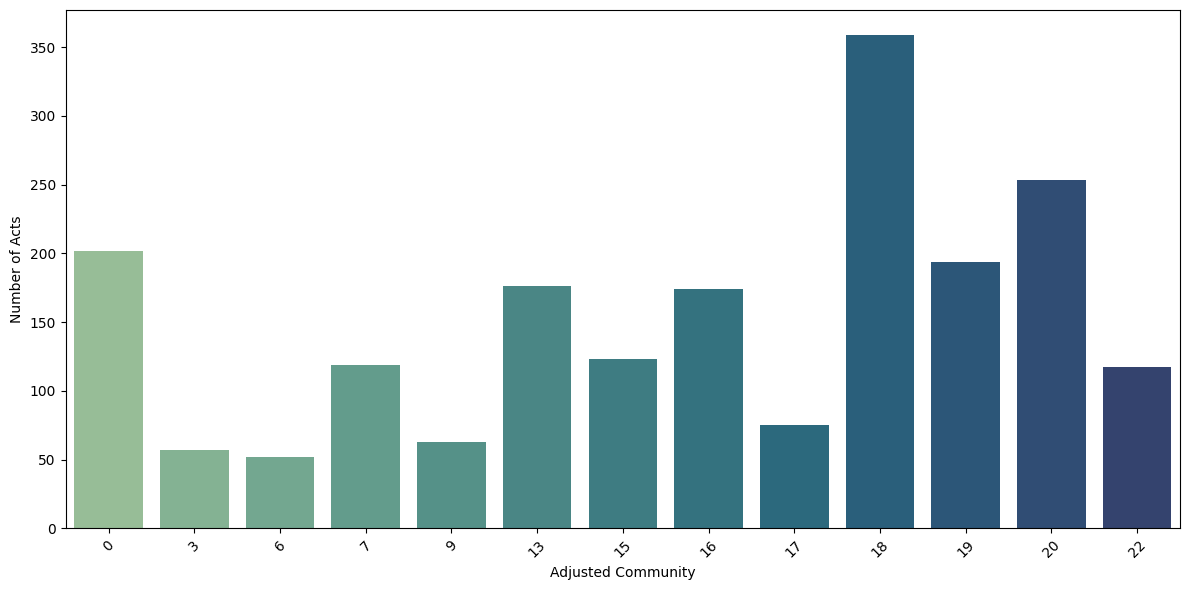

In [ ]:
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt

# # Convert to DataFrame
# adjusted_counts_df = act_counts.reset_index()
# adjusted_counts_df.columns = ["adjusted_community", "act_count"]

# # Plot
# plt.figure(figsize=(12, 6))
# sns.barplot(data=adjusted_counts_df, x="adjusted_community", y="act_count", palette="crest")
# plt.xlabel("Adjusted Community")
# plt.ylabel("Number of Acts")
# # plt.title("Number of Acts per Adjusted Community")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame
adjusted_counts_df = act_counts.reset_index()
adjusted_counts_df.columns = ["adjusted_community", "act_count"]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=adjusted_counts_df, x="adjusted_community", y="act_count", palette="crest")
plt.xlabel("Adjusted Community", fontsize=14)  # Increase font size here
plt.ylabel("Number of Acts", fontsize=14)      # Increase font size here
# plt.title("Number of Acts per Adjusted Community", fontsize=16)  # Optional: increase title font
plt.xticks(rotation=45, fontsize=12)  # Optional: increase tick label font size
plt.yticks(fontsize=12)               # Optional: increase y-axis tick label font size
plt.tight_layout()
plt.show()

NameError: name 'act_counts' is not defined

Visualize the Communities

In [43]:
import pandas as pd

#Read the original graph
G = nx.read_graphml("nz_legislation_network.graphml")  

#read the adjusted community mapping
df = pd.read_csv("acts_with_adjusted_communities.csv") 
community_map = df.set_index("name")["adjusted_community"].to_dict()

#assign to the graph
for node in G.nodes():
    act_name = G.nodes[node].get("name", node)
    G.nodes[node]["community"] = community_map.get(act_name, "unknown")

# Save the updated graph with communities
nx.write_gexf(G, "nz_legislation_with_adjusted_communities.gexf")
print("GEXF file with communities saved.")

GEXF file with communities saved.


## Topic Modeling

Prepare Documents for BERTopic

    Joins all act names in each community into a single text document

In [44]:
# Create one "document" per adjusted community (concatenated act titles)
grouped = df.groupby("adjusted_community")["name"].apply(lambda x: ". ".join(x)).reset_index()
documents = grouped["name"].tolist()
community_ids = grouped["adjusted_community"].tolist()

In [45]:
documents[0]

"Domestic Violence Act 1995. Crimes Act 1961. Family Violence Act 2018. Family Proceedings Act 1980. Children, Young Persons, and Their Families Act 1989. Criminal Procedure Act 2011. District Court Act 2016. Status of Children Act 1969. Property (Relationships) Act 1976. Protection of Personal and Property Rights Act 1988. Children, Young Persons, and Their Families (Oranga Tamariki) Legislation Act 2017. Domestic Violence—Victims' Protection Act 2018. Domestic Violence (Public Registers) Regulations 1998. Social Security Amendment Act 2005. Victims Rights Act 2002. Care of Children Act 2004. Bail Act 2000. Policing Act 2008. Corrections Act 2004. Evidence Act 2006. Oranga Tamariki Act 1989. Contempt of Court Act 2019. Plumbers, Gasfitters, and Drainlayers Act 2006. Dog Control Act 1996. Senior Courts Act 2016. Coroners Act 2006. Public Records Act 2005. Sentencing Act 2011. 1947 No 16. Judicial Conduct Commissioner and Judicial Conduct Panel Act 2004. Motor Vehicles Sales Act 2003. A

Topic Modeling with BERTopic

    BERTopic identifies semantic topics using embeddings
    Each community-document is assigned a topic_id
    Extracts keywords per topic

In [46]:
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# Number of communities after reassignment
n_clusters = len(community_ids)

vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)

# Create and fit BERTopic
topic_model = BERTopic(
    language="english",
    hdbscan_model=kmeans_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents)

# View summary
topic_info = topic_model.get_topic_info()
topic_info.to_csv("BERTopic_topic_summary_adjusted.csv", index=False)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-29 22:58:29,877 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
2025-06-29 22:58:34,819 - BERTopic - Embedding - Completed ✓
2025-06-29 22:58:34,819 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-29 22:58:37,881 - BERTopic - Dimensionality - Completed ✓
2025-06-29 22:58:37,881 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly s

In [47]:
topic_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,0,1,0_act_amendment_amendment act_court,"[act, amendment, amendment act, court, childre...",[Domestic Violence Act 1995. Crimes Act 1961. ...
1,1,1,1_transport_land transport_land_rule,"[transport, land transport, land, rule, transp...",[Land Transport Act 1998. Transport (Vehicle a...
2,2,1,2_electoral_electoral amendment_local_amendmen...,"[electoral, electoral amendment, local, amendm...",[Electoral Act 1993. Local Electoral Act 2001....
3,3,1,3_social_social security_security_act,"[social, social security, security, act, amend...",[Social Security Act 1964. Privacy Act 1993. A...
4,4,1,4_convention_relating_status_births deaths,"[convention, relating, status, births deaths, ...",[Act 1976. Immigration Act 2009. Immigration A...
5,5,1,5_land_act_act 1908_1908,"[land, act, act 1908, 1908, land act, maori, t...",[Relationships (Statutory References) Act 2005...
6,6,1,6_copyright_act_rules_amendment,"[copyright, act, rules, amendment, amendment a...","[Flags, Emblems, and Names Protection Act 1981..."
7,7,1,7_act_financial_securities_amendment act,"[act, financial, securities, amendment act, am...",[Contract and Commercial Law Act 2017. Financi...
8,8,1,8_regulations_substances_hazardous substances_...,"[regulations, substances, hazardous substances...",[Mining Act 1971. Health and Safety at Work (H...
9,9,1,9_act_amendment act_amendment_management,"[act, amendment act, amendment, management, co...",[Arms Act 1983. Summary Proceedings Act 1957. ...


Map Topic Back to Acts

    •	Assigns a BERTopic topic ID to each individual act
	•	Now every act has:
	•	its community ID (network-based)
	•	its semantic topic ID (text-based)

In [48]:
# Map each community to its topic
grouped["bertopic_topic"] = topics
topic_map = dict(zip(grouped["adjusted_community"], grouped["bertopic_topic"]))

# Assign topic to each act
df["bertopic_topic"] = df["adjusted_community"].map(topic_map)

# Save final result
df.to_csv("acts_with_adjusted_community_and_topics.csv", index=False)

In [49]:
display(df)

,name,community,adjusted_community,bertopic_topic
0,Domestic Violence Act 1995,0,0,0
1,Arms Act 1983,18,18,9
2,Crimes Act 1961,0,0,0
3,Family Violence Act 2018,0,0,0
4,Family Proceedings Act 1980,0,0,0
...,...,...,...,...
1959,Government Railways Act 1926,22,22,12
1960,National Provident Fund Restructuring Act 1990,22,22,12
1961,Education Act 1914,22,22,12
1962,Education Amendment Act 1920,22,22,12


In [50]:
#save final output to a csv file
df.to_csv("acts_with_community_and_topic.csv", index=False)
topic_model.get_topic_info().to_csv("BERTopic_topic_summary.csv", index=False)

### Generate Natural topics from the keywords given from BERTopic

    Label BERTopic Topics Using Anthropic Claude API

In [51]:
%pip install anthropic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import pandas as pd
# import anthropic
# import os
# import time

# # === Load the API key ===
# client = anthropic.Anthropic(
#     api_key=""
# )
# # === Load BERTopic summary ===
# df = pd.read_csv("BERTopic_topic_summary.csv")

# # === Prepare output storage ===
# labels = []

# # === Loop through topics and send prompts ===
# for i, row in df.iterrows():
#     topic_id = row["Topic"]
#     keywords = row["Representation"]
    
#     # Create the Claude prompt
#     prompt = f"""Given the following keywords from a topic modeling process:
# {keywords}

# Suggest a short, clear legal topic name (max 5 words) that best describes this group."""

#     # Send request to Claude
#     try:
#         response = client.messages.create(
#             model="claude-3-haiku-20240307",
#             max_tokens=300,
#             temperature=0.2,
#             messages=[
#                 {"role": "user", "content": prompt}
#             ]
#         )
#         label = response.content[0].text.strip()
#     except Exception as e:
#         label = f"ERROR: {e}"

#     print(f"Topic {topic_id}: {label}")
#     labels.append(label)
    
#     time.sleep(1)  # respectful delay to avoid rate limits

# # === Add new column and save ===
# df["topic_label"] = labels
# df.to_csv("BERTopic_topic_summary_labeled_Claude.csv", index=False)
# print("✅ Saved with topic labels to 'BERTopic_topic_summary_labeled_Claude.csv'")

In [ ]:
import pandas as pd
import anthropic
import re
import time

# Load BERTopic topic summary
df = pd.read_csv("BERTopic_topic_summary.csv")

# Clean keywords: remove years and "act"
def clean_keywords(text):
    text = re.sub(r'\b\d{4}\b', '', text)            # Remove years like 1995
    text = re.sub(r'\b[Aa]ct[s]?\b', '', text)        # Remove "act"/"acts"
    text = re.sub(r'\s+', ' ', text)                 # Collapse extra spaces
    return text.strip().strip(",").strip()

df["clean_keywords"] = df["Representation"].apply(clean_keywords)

# === Load the API key ===
client = anthropic.Anthropic(
    api_key=""
)
# Store labels
labels = []

# Generate topic labels using Claude
for i, row in df.iterrows():
    topic_id = row["Topic"]
    keywords = row["clean_keywords"]

    prompt = f"""
You are labeling legal topics.

Given the keywords: {keywords}

Suggest a clear and short topic label (max 5 words).
Avoid including the word "Act" or any years.
Use general legal or government terms.
Only return the label without any explanation.
"""

    try:
        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=50,
            temperature=0.5,
            messages=[{"role": "user", "content": prompt}]
        )
        label = response.content[0].text.strip()
    except Exception as e:
        label = f"ERROR: {e}"

    print(f"Topic {topic_id}: {label}")
    labels.append(label)
    time.sleep(1)  # avoid rate limits

# Save labels to file
df["topic_label"] = labels
df.to_csv("BERTopic_topic_summary_labeled_clean.csv", index=False)
print("✅ Saved with clean Claude topic labels!")

Topic 0: Constitutional Rights
Topic 1: Land Transport Regulations and Amendments
Topic 2: Electoral Law and Amendments
Topic 3: Social Security Amendments
Topic 4: Convention on Status of Births, Deaths, and Refugees
Topic 5: Maori Land Transfer Amendments
Topic 6: Constitutional Law and Commerce
Topic 7: Securities Regulation and Reporting
Topic 8: Hazardous Substances Regulation and Safety
Topic 9: Constitutional Law
Environmental Law
Civil Rights
Fisheries Management
Building Regulations
Resource Management
Topic 10: Income Tax Matters
Topic 11: Employment Relations Regulations
Topic 12: Education and Training Funding
✅ Saved with clean Claude topic labels!


In [54]:
import pandas as pd

# Load act-level data with BERTopic topic IDs
acts_df = pd.read_csv("acts_with_adjusted_community_and_topics.csv")

# Load topic label mapping
labels_df = pd.read_csv("BERTopic_topic_summary_labeled_clean.csv")

In [55]:
topic_map = dict(zip(labels_df["Topic"], labels_df["topic_label"]))

In [56]:
acts_df["topic_label"] = acts_df["bertopic_topic"].map(topic_map)

# Save the final result
acts_df.to_csv("acts_with_topic_labels_final.csv", index=False)
print("Final file saved: acts_with_topic_labels_final.csv")

Final file saved: acts_with_topic_labels_final.csv


In [57]:
import pandas as pd

df = pd.read_csv("acts_with_topic_labels_final.csv")

summary = df["topic_label"].value_counts().reset_index()
summary.columns = ["topic_label", "num_acts"]
summary.to_csv("topic_summary_table.csv", index=False)
print(summary)

                                          topic_label  num_acts
0   Constitutional Law\nEnvironmental Law\nCivil R...       359
1                    Employment Relations Regulations       253
2                               Constitutional Rights       202
3                                  Income Tax Matters       194
4                      Maori Land Transfer Amendments       176
5                 Securities Regulation and Reporting       174
6                     Constitutional Law and Commerce       123
7                          Social Security Amendments       119
8                      Education and Training Funding       117
9          Hazardous Substances Regulation and Safety        75
10  Convention on Status of Births, Deaths, and Re...        63
11          Land Transport Regulations and Amendments        57
12                       Electoral Law and Amendments        52


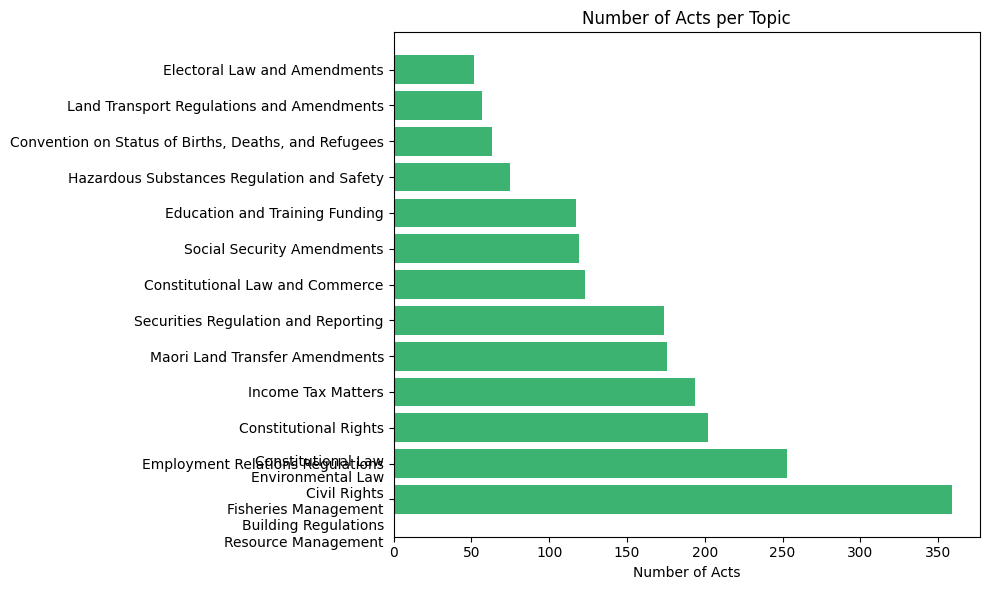

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(summary["topic_label"], summary["num_acts"], color="mediumseagreen")
plt.xlabel("Number of Acts")
plt.title("Number of Acts per Topic")
plt.tight_layout()
plt.savefig("topic_bar_chart.png")
plt.show()

Community vs Topic Cross-tab 

In [59]:
crosstab = pd.crosstab(df["adjusted_community"], df["topic_label"])
crosstab.to_csv("community_vs_topic_matrix.csv")

In [60]:
# %pip install seaborn

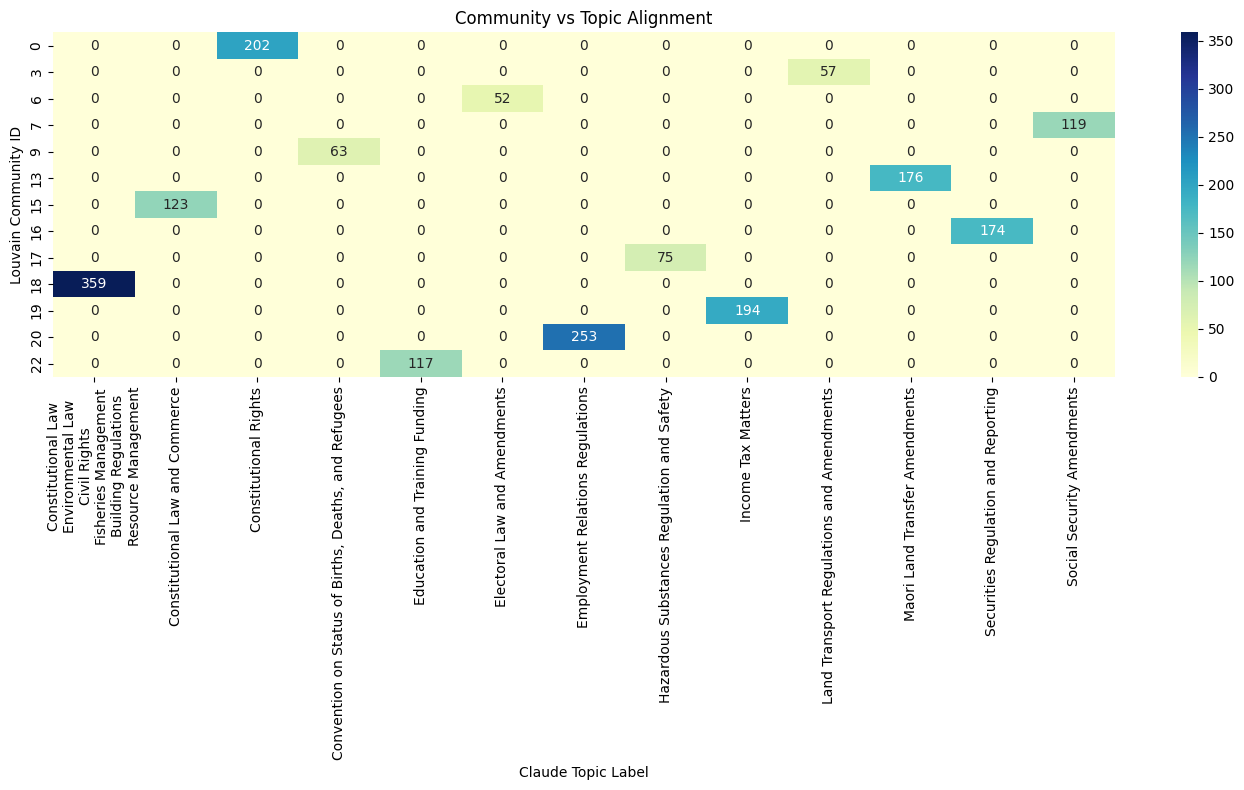

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

crosstab = pd.read_csv("community_vs_topic_matrix.csv", index_col=0)

plt.figure(figsize=(14, 8))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Community vs Topic Alignment")
plt.xlabel("Claude Topic Label")
plt.ylabel("Louvain Community ID")
plt.tight_layout()
plt.savefig("community_topic_heatmap.png")
plt.show()

The below code with internal reference topic keywords,

Checks semantic coherence between:

	1. the Claude-generated label
	2. and the top keywords extracted from that topic


To assess topic coherence, we compared each topic’s top keywords to a reference list derived from its own label. This provided an internal consistency check — whether a topic’s keywords semantically supported the label assigned by Claude. While not an external validation, this method helped confirm which topics were more focused or thematically diffuse.


In [62]:
import pandas as pd
import ast
import re

# === Step 1: Load topic summary file ===
df = pd.read_csv("BERTopic_topic_summary_labeled_clean.csv")  # Make sure this is the correct file

# === Step 2: Properly clean the Representation column ===
def clean_keywords(text):
    try:
        raw_list = ast.literal_eval(text)
    except Exception:
        return []

    cleaned = []
    for kw in raw_list:
        kw = kw.lower()
        kw = re.sub(r'\b\d{4}\b', '', kw)        # Remove years
        kw = re.sub(r'\bact[s]?\b', '', kw)      # Remove 'act' or 'acts'
        kw = re.sub(r'[^\w\s-]', '', kw)         # Remove punctuation
        kw = kw.strip()
        if kw:
            cleaned.append(kw)
    return cleaned

df["clean_keywords"] = df["Representation"].apply(clean_keywords)

# === Step 3: Define your own reference topics ===
reference_topics = {
    "Taxation and Income Matters": ["tax", "income", "remedial", "budget", "finance"],
    "Local Government Land Management": ["local", "government", "land", "planning", "management"],
    "Constitutional Rights and Criminal Law": ["rights", "court", "criminal", "justice", "offense", "law"],
    "Constitutional Amendments and Regulations": ["amendment", "constitution", "regulation", "provision", "reform"],
    "Federal Court Rules and Amendments": ["court", "rules", "procedure", "amendment", "litigation"],
    "Copyright & Intellectual Property": ["copyright", "intellectual", "property", "licensing", "infringement"],
    "Securities Regulation and Financial Law": ["securities", "regulation", "finance", "investment", "company"],
    "Maori Land and Mining Rights": ["maori", "land", "mining", "customary", "iwi"],
    "Hazardous Substances Regulation and Commerce": ["hazardous", "substance", "regulation", "commerce", "chemical"],
    "Education Amendments and Funding": ["education", "school", "university", "learning", "funding"],
    "Employment and Parental Leave Protections": ["employment", "parental", "leave", "protection", "worker"],
    "Land Transport Regulations and Amendments": ["transport", "vehicle", "road", "amendment", "traffic"],
    "International Births and Deaths Registration": ["birth", "death", "international", "registration", "identity"],
    "Electoral Law and Amendments": ["election", "electoral", "vote", "law", "amendment"]
}

##external topics
# reference_topics = {
#     "Justice and Courts": ["court", "criminal", "justice", "legal", "offense", "prosecution", "sentencing", "trial"],
#     "Health and Public Welfare": ["health", "care", "public", "mental", "medical", "welfare", "disability", "hospital"],
#     "Education and Training": ["education", "school", "student", "learning", "university", "training", "teacher"],
#     "Māori Affairs": ["māori", "iwi", "hapū", "treaty", "settlement", "customary", "whānau", "tikanga"],
#     "Finance and Taxation": ["tax", "income", "finance", "budget", "remedial", "fiscal", "expenditure", "funding"],
#     "Environment and Conservation": ["environment", "natural", "resource", "land", "hazard", "conservation", "wildlife", "climate"],
#     "Commerce and Companies": ["company", "corporate", "business", "commercial", "securities", "investment", "trading"],
#     "Transport and Infrastructure": ["transport", "vehicle", "road", "rail", "traffic", "network", "highway"],
#     "Labour and Employment": ["employment", "worker", "union", "wages", "leave", "employer", "labour"],
#     "Foreign Affairs and Treaties": ["international", "foreign", "agreement", "treaty", "diplomatic", "relation"],
#     "Civil Rights and Constitution": ["rights", "constitution", "amendment", "freedom", "citizen", "protection"],
# }

# === Step 4: Calculate similarity score ===
def similarity_score(topic_keywords, ref_keywords):
    topic_set = set(topic_keywords)
    ref_set = set(ref_keywords)
    return len(topic_set & ref_set) / len(ref_set)

# Apply similarity scoring
for label, ref_keywords in reference_topics.items():
    df[label] = df["clean_keywords"].apply(lambda kws: similarity_score(kws, ref_keywords))

# Find best match and score
df["best_match"] = df[list(reference_topics.keys())].idxmax(axis=1)
df["match_score"] = df[list(reference_topics.keys())].max(axis=1)

# === Step 5: Save output ===
df.to_csv("topic_similarity_scores_internal_validation.csv", index=False)
print("✅ Saved: topic_similarity_scores.csv with real similarity scores 2.")

✅ Saved: topic_similarity_scores.csv with real similarity scores 2.


In [67]:
import pandas as pd
import ast
import re

# === Step 1: Load your BERTopic topic summary ===
df = pd.read_csv("BERTopic_topic_summary_labeled_clean_new.csv")

# === Step 2: Clean the keyword lists ===
def clean_keywords(text):
    try:
        raw_list = ast.literal_eval(text)
    except Exception:
        return []

    cleaned = []
    for kw in raw_list:
        kw = kw.lower()
        kw = re.sub(r'\b\d{4}\b', '', kw)        # Remove years
        kw = re.sub(r'\bact[s]?\b', '', kw)      # Remove 'act' or 'acts'
        kw = re.sub(r'[^\w\s-]', '', kw)         # Remove punctuation
        kw = kw.strip()
        if kw:
            cleaned.append(kw)
    return cleaned

df["clean_keywords"] = df["Representation"].apply(clean_keywords)

# === Step 3: Define parliamentary committees and their keywords ===
committee_keywords = {
    "Economic Development, Science and Innovation": [
        "business", "development", "tourism", "minerals", "commerce", "consumer", "trading",
        "research", "science", "innovation", "intellectual", "property", "broadcasting", "communications", "technology"
    ],
    "Education and Workforce": [
        "education", "training", "employment", "immigration", "industrial", "relations", "safety", "compensation"
    ],
    "Environment": [
        "conservation", "environment", "climate", "change"
    ],
    "Finance and Expenditure": [
        "economic", "fiscal", "policy", "taxation", "revenue", "banking", "finance", "superannuation",
        "insurance", "expenditure", "audit"
    ],
    "Foreign Affairs, Defence and Trade": [
        "customs", "defence", "disarmament", "arms", "control", "foreign", "affairs", "trade", "veterans"
    ],
    "Governance and Administration": [
        "parliamentary", "legislative", "services", "prime", "cabinet", "state", "statistics", "internal",
        "civil", "emergency", "local", "government"
    ],
    "Health": [
        "health"
    ],
    "Justice": [
        "constitutional", "electoral", "rights", "justice", "courts", "crime", "criminal", "police",
        "corrections", "legal"
    ],
    "Māori Affairs": [
        "maori", "treaty", "negotiations"
    ],
    "Primary Production": [
        "agriculture", "biosecurity", "racing", "fisheries", "forestry", "lands", "land", "information"
    ],
    "Social Services and Community": [
        "social", "development", "housing", "income", "support", "women", "children", "youth",
        "seniors", "pacific", "ethnic", "communities", "arts", "culture", "heritage", "sport", "recreation", "voluntary"
    ],
    "Transport and Infrastructure": [
        "transport", "safety", "infrastructure", "energy", "building", "construction"
    ]
}

# === Step 4: Jaccard similarity calculation ===
def jaccard_similarity(topic_keywords, ref_keywords):
    topic_set = set(topic_keywords)
    ref_set = set(ref_keywords)
    intersection = topic_set & ref_set
    union = topic_set | ref_set
    if not union:
        return 0.0
    return len(intersection) / len(union)

# Calculate similarity for each committee
for committee, ref_keywords in committee_keywords.items():
    df[committee] = df["clean_keywords"].apply(lambda kws: jaccard_similarity(kws, ref_keywords))

# Find best match
df["best_committee_match"] = df[list(committee_keywords.keys())].idxmax(axis=1)
df["similarity_score"] = df[list(committee_keywords.keys())].max(axis=1)

# === Step 5: Save the results ===
df.to_csv("topic_committee_similarity2.csv", index=False)
print("✅ Saved: topic_committee_similarity2.csv with best committee match and similarity scores.")

✅ Saved: topic_committee_similarity2.csv with best committee match and similarity scores.


In [68]:
import pandas as pd
import ast
import re

# === Step 1: Load your BERTopic topic summary ===
df = pd.read_csv("BERTopic_topic_summary_labeled_clean.csv")

# === Step 2: Properly clean the Representation column ===
def clean_keywords(text):
    try:
        raw_list = ast.literal_eval(text)
    except Exception:
        return []

    cleaned = []
    for kw in raw_list:
        kw = kw.lower()
        kw = re.sub(r'\b\d{4}\b', '', kw)        # Remove years
        kw = re.sub(r'\bact[s]?\b', '', kw)      # Remove 'act' or 'acts'
        kw = re.sub(r'[^\w\s-]', '', kw)         # Remove punctuation
        kw = kw.strip()
        if kw:
            cleaned.append(kw)
    return cleaned

df["clean_keywords"] = df["Representation"].apply(clean_keywords)

# === Step 3: Define nz parliamentary reference topics ===
reference_topics = {
    "Transport and Infrastructure": [
        "transport", "transport safety", "infrastructure", "energy", "building" , "construction"
    ],
    "Labour and Employment": [
        "employment", "worker", "union", "wages", "leave", "employer", "strike", "job", "contract", "workplace", "parental leave"
    ],
    "Governance and Electoral Affairs": [
        "electoral", "election", "vote", "parliament", "campaign", "voting", "electorate", "referendum", "broadcasting"
    ],
    "Constitution and Justice": [
        "constitution", "amendment", "law", "rights", "freedom", "citizen", "judicial", "governance", "protection", "democracy"
    ],
    "Justice and Courts": [
        "court", "criminal", "justice", "legal", "offense", "prosecution", "sentencing", "trial", "judge", "lawyer", "conviction"
    ],
    "Copyright and Intellectual Property": [
        "copyright", "intellectual", "property", "licensing", "infringement", "patent", "trademark", "ownership", "content", "publishing"
    ],
    "Finance and Taxation": [
        "tax", "income", "finance", "budget", "remedial", "fiscal", "expenditure", "gst", "taxpayer", "revenue"
    ],
    "Education and Training": [
        "education", "school", "student", "learning", "university", "training", "teacher", "academic", "curriculum", "institution"
    ],
    "Commerce and Securities Regulation": [
        "company", "corporate", "securities", "investment", "regulation", "business", "shares", "enterprise", "bankruptcy", "compliance"
    ],
    "Local Government and Planning": [
        "local", "council", "district", "zoning", "planning", "resource", "authority", "municipal", "development"
    ],
    "Māori Affairs and Land Rights": [
        "māori", "iwi", "hapū", "treaty", "settlement", "customary", "tikanga", "whānau", "taonga", "sovereignty", "land", "tribal"
    ],
    "Births and Civil Records": [
        "births", "deaths", "marriage", "registration", "record", "identity", "certificate", "citizenship", "registrar"
    ],
    "Environment and Hazardous Substances": [
        "environment", "natural", "hazard", "pollution", "waste", "hazardous", "substance", "chemical", "safety", "climate", "dangerous goods"
    ]
}

# === Step 4: Calculate Jaccard similarity ===
def jaccard_similarity(topic_keywords, ref_keywords):
    topic_set = set(topic_keywords)
    ref_set = set(ref_keywords)
    intersection = topic_set & ref_set
    union = topic_set | ref_set
    if not union:
        return 0.0
    return len(intersection) / len(union)

# Apply Jaccard similarity scoring
for label, ref_keywords in reference_topics.items():
    df[label] = df["clean_keywords"].apply(lambda kws: jaccard_similarity(kws, ref_keywords))

# Determine best match and score
df["best_match"] = df[list(reference_topics.keys())].idxmax(axis=1)
df["match_score"] = df[list(reference_topics.keys())].max(axis=1)

# === Step 5: Save final results ===
df.to_csv("topic_similarity_scores_external2.csv", index=False)
print("✅ Saved: topic_similarity_scores_external2.csv with updated Jaccard similarity scores.")

✅ Saved: topic_similarity_scores_external2.csv with updated Jaccard similarity scores.


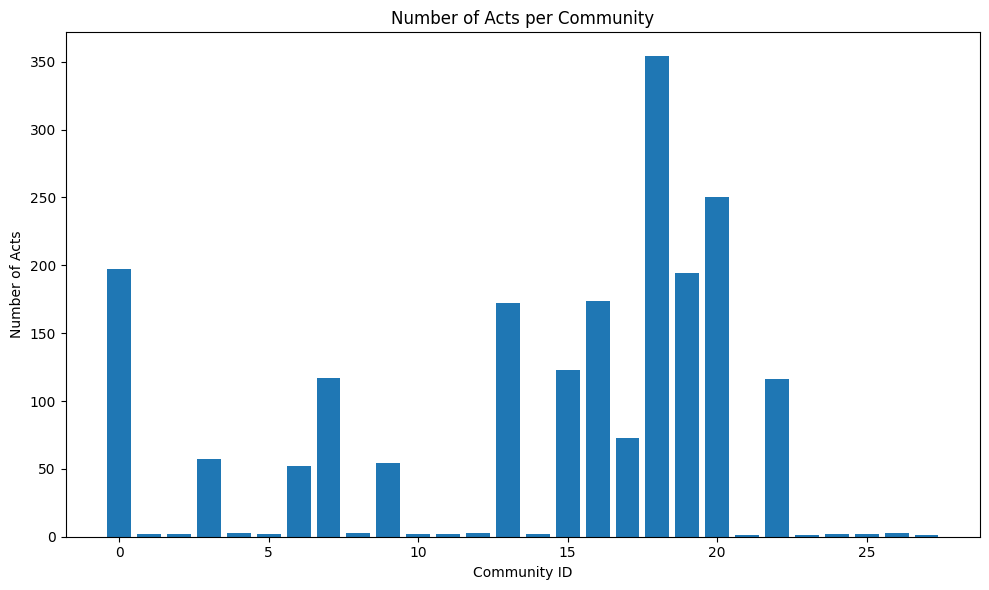

In [65]:
import matplotlib.pyplot as plt
from collections import Counter

# Count number of acts per community
community_counts = Counter(partition.values())

# Bar chart
plt.figure(figsize=(10,6))
plt.bar(community_counts.keys(), community_counts.values())
plt.xlabel("Community ID")
plt.ylabel("Number of Acts")
plt.title("Number of Acts per Community")
plt.tight_layout()
plt.show()